# Implementación de algoritmo de detección de Whitaker y Hayes

Basado en el trabajo https://doi.org/10.1016/j.chemolab.2018.06.009.

Carga de librerías externas, configuración de los parámetros a ser explorados durante la medición y número de archivos de recolección de datos.

In [19]:
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
from random import sample, randrange
from joblib import Parallel, delayed
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, f1_score

numero_procesos_concurrentes = 10
numero_archivos = 10
params = [
    { 'umbral': 8 },
    { 'umbral': 10 },
    { 'umbral': 12 },
    { 'umbral': 14 },
    { 'umbral': 16 },
    { 'umbral': 18 },
    { 'umbral': 20 },
    { 'umbral': 22 },
    { 'umbral': 24 },
    { 'umbral': 26 },
]

Funciones de carga de espectros

In [20]:
def deserializar_espectro(espectro):
    espectro['vector_base'] = np.array(espectro['vector_base'])
    espectro['espectro_base_muestra'] = np.array(espectro['espectro_base_muestra'])
    espectro['espectro_base_background'] = np.array(espectro['espectro_base_background'])
    espectro['baseline_muestra'] = np.array(espectro['baseline_muestra'])
    espectro['baseline_background'] = np.array(espectro['baseline_background'])
    espectro['muestra_con_baseline'] = np.array(espectro['muestra_con_baseline'])
    espectro['background_con_baseline'] = np.array(espectro['background_con_baseline'])
    espectro['muestra_combinado_base'] = np.array(espectro['muestra_combinado_base'])
    espectro['espectro_ruido_combinado'] = np.array(espectro['espectro_ruido_combinado'])
    espectro['espectro_ruido_background'] = np.array(espectro['espectro_ruido_background'])
    espectro['spikes_muestra'] = np.array(espectro['spikes_muestra'])
    espectro['spikes_background'] = np.array(espectro['spikes_background'])
    espectro['flag_spikes_muestra'] = np.array(espectro['flag_spikes_muestra'])
    espectro['flag_spikes_background'] = np.array(espectro['flag_spikes_background'])
    espectro['muestra_base_con_spikes'] = np.array(espectro['muestra_base_con_spikes'])
    espectro['y_muestra'] = np.array(espectro['y_muestra'])
    espectro['y_background'] = np.array(espectro['y_background'])

    return espectro

def cargar_espectros(nombre_archivo):
    with open(nombre_archivo, 'r') as fp:
        data = []
        for line in fp:
            data.append(deserializar_espectro(json.loads(line)))
        fp.close()
        return data

Función para calcular métricas clasificación de spikes.

In [21]:
def calcular_metricas_clasificacion(valores_reales, predicciones):
    _predicciones = np.array(predicciones).flatten()
    _valores_reales = np.array(valores_reales).flatten()

    return precision_recall_fscore_support(_valores_reales, _predicciones), confusion_matrix(_valores_reales, _predicciones)

Implementación del algoritmo Whitaker-Hayes para detección de spikes, así como funciones auxiliares para recogida de datos y visualización de resultados.

In [22]:
def algoritmo_whitaker_hayes(input, umbral = 6):
    # Primero calculamos la serie diferenciada
    input = input
    serie_diferenciada = np.diff(input)

    # Luego calculamos la mediana y el MAD de la serie diferenciada
    mediana_diferenciada = np.median(serie_diferenciada)
    mad_diferenciada = np.median(np.array(list(map(lambda x: abs(x - mediana_diferenciada), serie_diferenciada))))

    # En este caso el input es un vector nulo y se previene una división por cero
    if mad_diferenciada == 0:
        return np.full(len(input), False), np.zeros(len(input) - 1), np.zeros(len(input) - 1)

    # Calculamos el valor zeta modificado
    zeta_modificado = np.array(list(map(lambda x: 0.6745 * (x - mediana_diferenciada) / mad_diferenciada, serie_diferenciada)))

    # Son marcados como spikes los valores cuyo puntaje z modificado asociado cae por encima o por debajo del umbral
    resultado = np.abs(zeta_modificado) > umbral

    # Este algoritmo no puede detectar spikes en el primer valor de la serie,
    # los autores indican que, puesto que los spikes son sustituidos con promedios móviles
    # lo más seguro es marcar como spikes el primer y último elemento de la serie
    # Sin embargo, nuestro interés es sólo la detección, por lo que más bien nos interesa
    # preservar la precisión del algoritmo marcando como False el primer elemento, puesto
    # que esta es la elección más probable
    resultado = np.insert(resultado, 0, False)

    return resultado, serie_diferenciada, zeta_modificado

def obtener_resultado_parametro_whitaker_hayes(espectros, etiquetas, umbral = 6):
    predicciones_whitaker_hayes = [algoritmo_whitaker_hayes(espectro, umbral)[0] for espectro in espectros]

    return predicciones_whitaker_hayes, calcular_metricas_clasificacion(etiquetas, predicciones_whitaker_hayes)

def visualizar_resultado_whitaker_hayes(vector_base, input, etiquetas, umbral = 6):
    resultados, serie_diferenciada, zeta_modificado = algoritmo_whitaker_hayes(input, umbral)

    fig = plt.figure(figsize=[45, 45], constrained_layout=True)

    fig.suptitle("Muestra de resultados al aplicar el algoritmo Whitaker-Hayes", fontsize=24, fontweight='bold')

    subfigs = fig.subfigures(nrows=4, ncols=1)

    for row, subfig in enumerate(subfigs):
        (ax) = subfig.subplots(nrows=1, ncols=1)

        if row == 0:
            ax.set_title("Serie original", fontsize=18)
            ax.plot(vector_base, input)
        elif row == 1:
            ax.set_title("Serie diferenciada", fontsize=18)
            serie_diferenciada = np.insert(serie_diferenciada, 0, 0)
            ax.plot(vector_base, serie_diferenciada)
        elif row == 2:
            ax.set_title("Zeta modificado y umbral", fontsize=18)
            zeta_modificado = np.insert(zeta_modificado, 0, 0)
            ax.plot(vector_base, zeta_modificado)
            plt.axhline(y = umbral, color = 'r', linestyle = '-')
            plt.axhline(y = -umbral, color = 'r', linestyle = '-')
        elif row == 3:
            categorias = {
                'tp': {
                    'color': 'blue',
                    'label': 'Detecciones'
                },
                'fp': {
                    'color': 'black',
                    'label': 'Falsos positivos'
                },
                'fn': {
                    'color': 'red',
                    'label': 'Falsos negativos'
                }
            }

            detecciones_agrupadas = []

            for i, es_resultado in enumerate(resultados):
                label = ''
                es_spike = etiquetas[i]

                if es_spike:
                    if es_resultado:
                        label = 'tp'
                    else:
                        label = 'fn'
                elif es_resultado:
                    label = 'fp'
                else:
                    label = 'tn'
                detecciones_agrupadas.append(label)

            detecciones_agrupadas = np.array(detecciones_agrupadas)

            ax.set_title("Serie con spikes detectados y tipos de detección", fontsize=18)
            ax.plot(vector_base, input)
            ax.scatter(vector_base[detecciones_agrupadas == 'tp'], input[detecciones_agrupadas == 'tp'], c=categorias['tp']['color'], label=categorias['tp']['label'], s=100)
            ax.scatter(vector_base[detecciones_agrupadas == 'fp'], input[detecciones_agrupadas == 'fp'], c=categorias['fp']['color'], label=categorias['fp']['label'], s=100)
            ax.scatter(vector_base[detecciones_agrupadas == 'fn'], input[detecciones_agrupadas == 'fn'], c=categorias['fn']['color'], label=categorias['fn']['label'], s=100)

            ax.legend(fontsize=28)

Recogida de datos y guardado de los resultados en un archivo.

In [23]:
resultados_whitaker_hayes_ruido = []
resultados_whitaker_hayes_sin_ruido = []

def aux_procesamiento_paralelo_archivos(n):
    nombre_archivo = '../resultados_' + str(n) + '.ndjson'

    resultados_ruido = []
    resultados_sin_ruido = []

    espectros = cargar_espectros(nombre_archivo)

    espectros_base_con_spikes_con_ruido = []
    espectros_base_con_spikes_sin_ruido = []
    etiquetas = []

    for espectro in espectros:
        espectros_base_con_spikes_con_ruido.append(espectro['muestra_base_con_spikes'])
        espectros_base_con_spikes_sin_ruido.append(espectro['espectro_base_muestra'] + espectro['spikes_muestra'])
        etiquetas.append(espectro['flag_spikes_muestra'])

    predicciones_whitaker_hayes_ruido, metricas_whitaker_hayes_ruido = obtener_resultado_parametro_whitaker_hayes(espectros_base_con_spikes_con_ruido, etiquetas, param['umbral'])
    predicciones_whitaker_hayes_sin_ruido, metricas_whitaker_hayes_sin_ruido = obtener_resultado_parametro_whitaker_hayes(espectros_base_con_spikes_sin_ruido, etiquetas, param['umbral'])

    resultados_ruido.append({
        'precision_negativos': metricas_whitaker_hayes_ruido[0][0][0],
        'precision_positivos': metricas_whitaker_hayes_ruido[0][0][1],
        'support_negativos': metricas_whitaker_hayes_ruido[0][1][0],
        'support_positivos': metricas_whitaker_hayes_ruido[0][1][1],
        'f1_negativos': metricas_whitaker_hayes_ruido[0][2][0],
        'f1_positivos': metricas_whitaker_hayes_ruido[0][2][1],
        'vn': metricas_whitaker_hayes_ruido[1][0][0],
        'fp': metricas_whitaker_hayes_ruido[1][0][1],
        'fn': metricas_whitaker_hayes_ruido[1][1][0],
        'vp': metricas_whitaker_hayes_ruido[1][1][1]
    })

    resultados_sin_ruido.append({
        'precision_negativos': metricas_whitaker_hayes_sin_ruido[0][0][0],
        'precision_positivos': metricas_whitaker_hayes_sin_ruido[0][0][1],
        'support_negativos': metricas_whitaker_hayes_sin_ruido[0][1][0],
        'support_positivos': metricas_whitaker_hayes_sin_ruido[0][1][1],
        'f1_negativos': metricas_whitaker_hayes_sin_ruido[0][2][0],
        'f1_positivos': metricas_whitaker_hayes_sin_ruido[0][2][1],
        'vn': metricas_whitaker_hayes_sin_ruido[1][0][0],
        'fp': metricas_whitaker_hayes_sin_ruido[1][0][1],
        'fn': metricas_whitaker_hayes_sin_ruido[1][1][0],
        'vp': metricas_whitaker_hayes_sin_ruido[1][1][1]
    })

    return resultados_ruido, resultados_sin_ruido

for i, param in enumerate(params):
    resultados_archivo = Parallel(n_jobs=numero_procesos_concurrentes)(
        delayed(aux_procesamiento_paralelo_archivos)(n) for n in range(numero_archivos)
    )
    
    resultados_ruido = [resultado[0][0] for resultado in resultados_archivo]
    resultados_sin_ruido = [resultado[1][0] for resultado in resultados_archivo]

    resultados_whitaker_hayes_ruido.append({
        'param': param,
        'resultados': resultados_ruido
    })

    resultados_whitaker_hayes_sin_ruido.append({
        'param': param,
        'resultados': resultados_sin_ruido
    })

with open('resultados_whitaker_hayes_ruido', 'wb') as fp:
    pickle.dump(resultados_whitaker_hayes_ruido, fp)
    fp.close()

with open('resultados_whitaker_hayes_sin_ruido', 'wb') as fp:
    pickle.dump(resultados_whitaker_hayes_sin_ruido, fp)
    fp.close()

Aquí obtenemos y guardamos en un archivo los peores resultados obtenidos por el algoritmo con sus mejores parámetros (con o sin ruido) para posterior análisis

In [24]:
lista_medias_f1_positivos_ruido = [np.mean([resultado['f1_positivos'] for resultado in resultado_param['resultados']]) for resultado_param in resultados_whitaker_hayes_ruido]
indice_mejores_params_ruido = np.argmax(lista_medias_f1_positivos_ruido)
mejores_params_ruido = params[indice_mejores_params_ruido]

lista_medias_f1_positivos_sin_ruido = [np.mean([resultado['f1_positivos'] for resultado in resultado_param['resultados']]) for resultado_param in resultados_whitaker_hayes_sin_ruido]
indice_mejores_params_sin_ruido = np.argmax(lista_medias_f1_positivos_sin_ruido)
mejores_params_sin_ruido = params[indice_mejores_params_sin_ruido]

archivo_azar = randrange(numero_archivos)

nombre_archivo = '../resultados_' + str(archivo_azar) + '.ndjson'

espectros = cargar_espectros(nombre_archivo)

predicciones_ruido = [algoritmo_whitaker_hayes(espectro['muestra_base_con_spikes'], mejores_params_ruido['umbral'])[0] for espectro in espectros]
predicciones_sin_ruido = [algoritmo_whitaker_hayes(espectro['espectro_base_muestra'] + espectro['spikes_muestra'], mejores_params_sin_ruido['umbral'])[0] for espectro in espectros]

resultados_f1_ruido = [(
    espectro['muestra_base_con_spikes'],
    f1_score(espectro['flag_spikes_muestra'], predicciones_ruido[i], zero_division=1),
    predicciones_ruido[i],
    espectro['flag_spikes_muestra'],
    mejores_params_ruido
) for i, espectro in enumerate(espectros)]

resultados_f1_sin_ruido = [(
    espectro['espectro_base_muestra'] + espectro['spikes_muestra'],
    f1_score(espectro['flag_spikes_muestra'], predicciones_sin_ruido[i], zero_division=1),
    predicciones_sin_ruido[i],
    espectro['flag_spikes_muestra'],
    mejores_params_sin_ruido
) for i, espectro in enumerate(espectros)]

resultados_f1_ruido = list(filter(lambda d: d[1] > 0, resultados_f1_ruido))
resultados_f1_sin_ruido = list(filter(lambda d: d[1] > 0, resultados_f1_sin_ruido))

resultados_f1_ruido = sorted(resultados_f1_ruido, key=lambda d: d[1])
resultados_f1_sin_ruido = sorted(resultados_f1_sin_ruido, key=lambda d: d[1])

with open('peores_resultados_whitaker_hayes', 'wb') as fp:
    peores_resultados_ruido = resultados_f1_ruido[0:10]
    peores_resultados_sin_ruido = resultados_f1_sin_ruido[0:10]
    peores_resultados = {
        'ruido': peores_resultados_ruido,
        'sin_ruido': peores_resultados_sin_ruido
    }
    pickle.dump(peores_resultados, fp)
    fp.close()

Toma de una muestra aleatoria para control de calidad

In [25]:
indice_muestra = sample(list(range(len(espectros))), 1)[0]

Visualización del resultado de la aplicación del algoritmo Whitaker-Hayes a un espectro aleatorio al que no le fue añadido ruido aleatorio

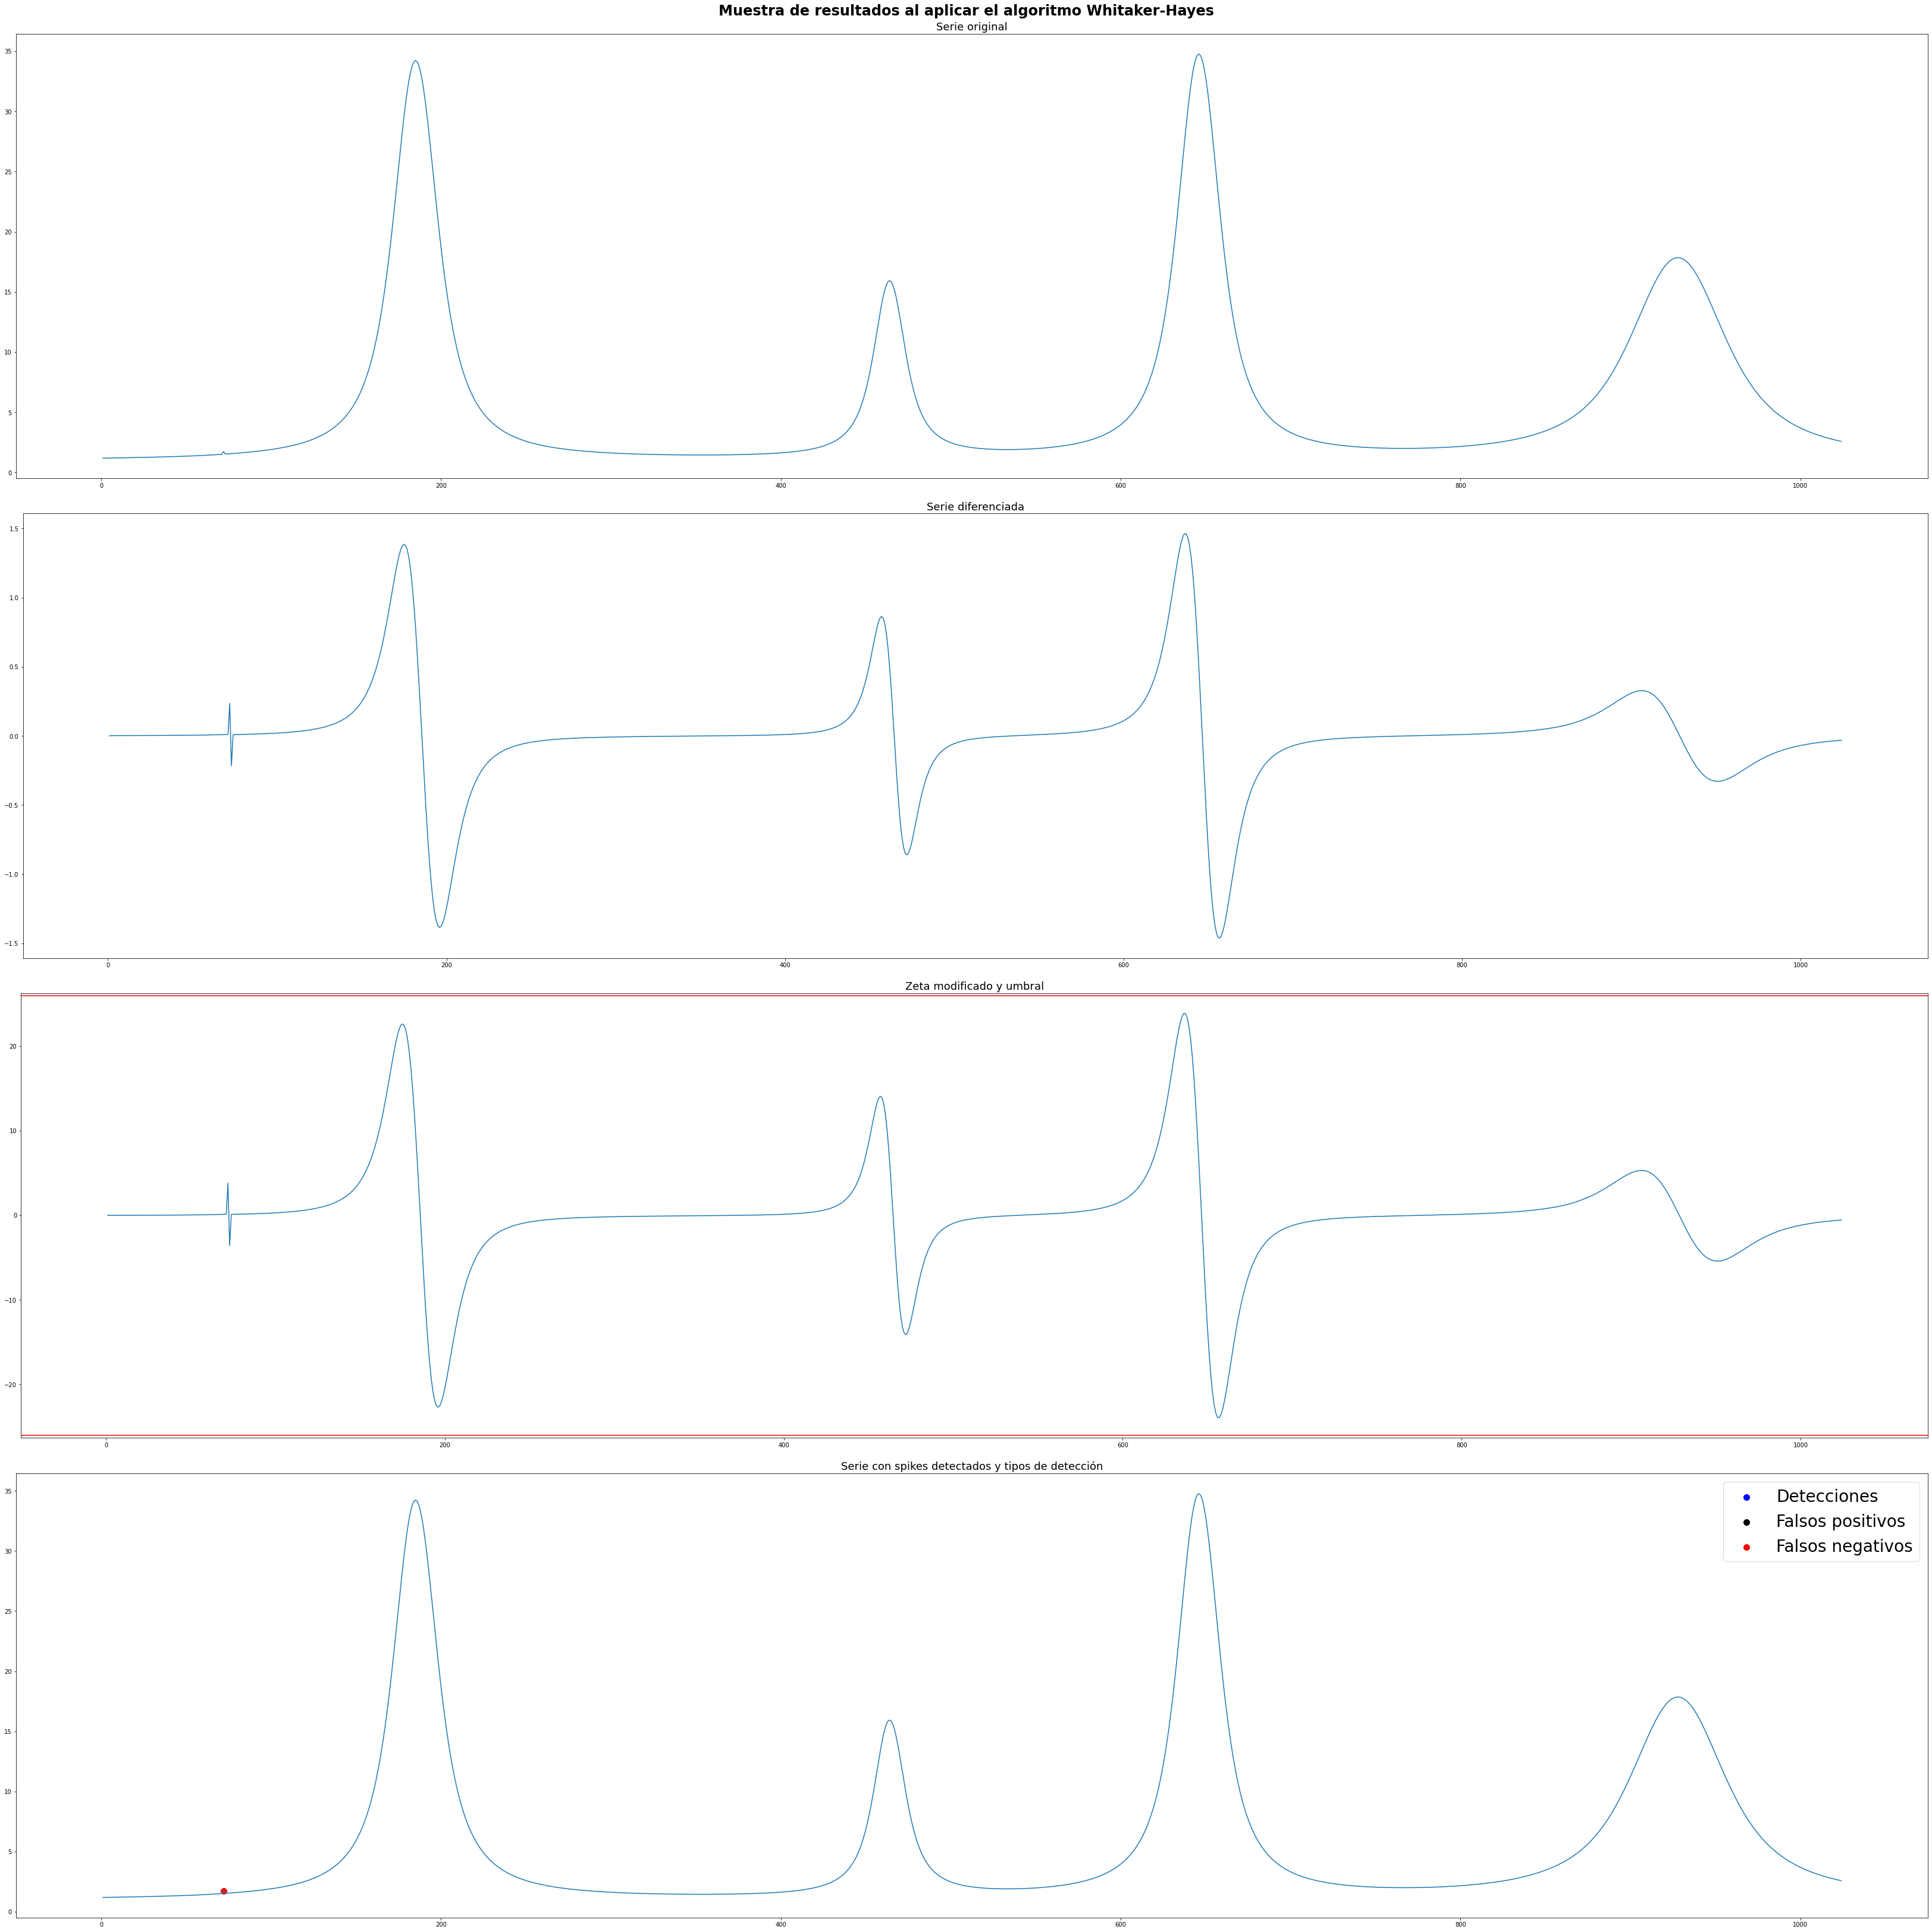

In [26]:
visualizar_resultado_whitaker_hayes(
    espectros[indice_muestra]['vector_base'],
    espectros[indice_muestra]['espectro_base_muestra'] + espectros[indice_muestra]['spikes_muestra'],
    espectros[indice_muestra]['flag_spikes_muestra'],
    mejores_params_sin_ruido['umbral']
)

Visualización del resultado de la aplicación del algoritmo Whitaker-Hayes a un espectro aleatorio al que le fue añadido ruido aleatorio

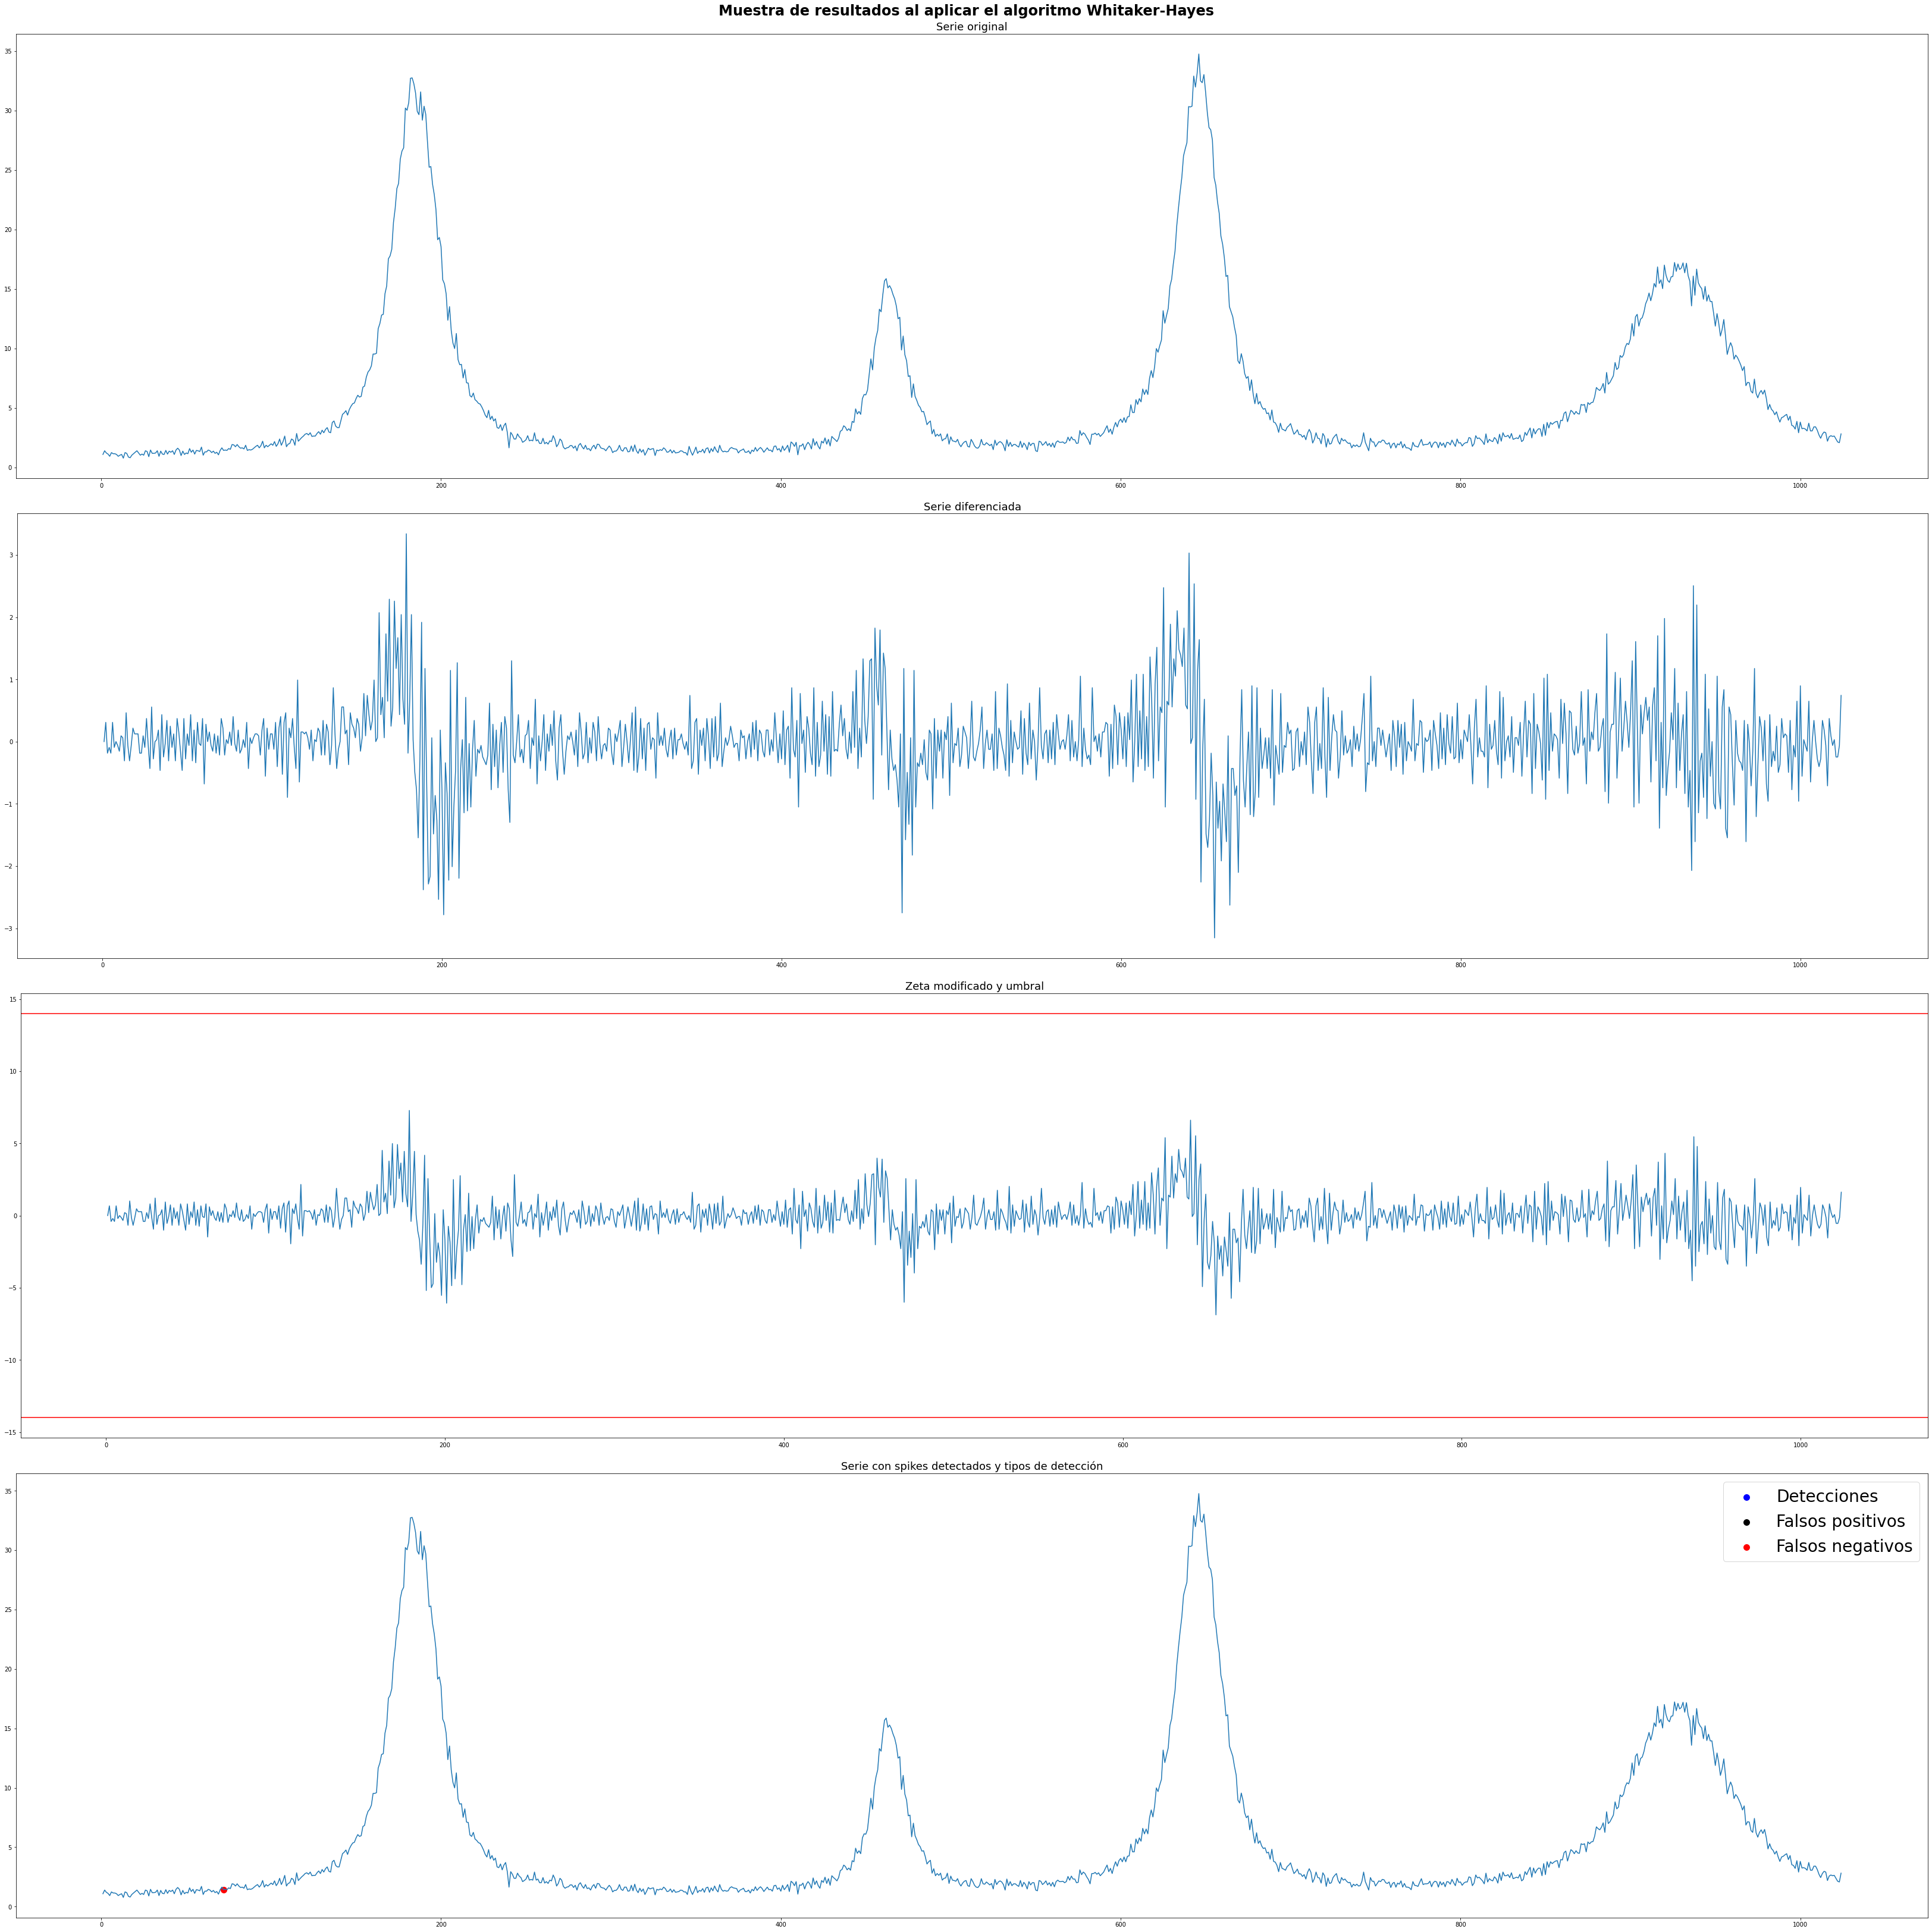

In [27]:
visualizar_resultado_whitaker_hayes(
    espectros[indice_muestra]['vector_base'],
    espectros[indice_muestra]['muestra_base_con_spikes'],
    espectros[indice_muestra]['flag_spikes_muestra'],
    mejores_params_ruido['umbral']
)